### this file has: Updated Fitting Function (free params) + Updated Guesses

In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [2]:
sga_ids = [9769, 11977, 12892, 14501, 16383, 19235, 19278, 25532, 30149, 31220, 32484, 36904, 37543, 46327, 58617, 73111, 88963, 91660, 90791, 106536, 
           114405, 114489, 122580, 126630, 125611, 128163, 128411, 130766, 149502, 153504, 175220, 176736, 184044, 186239, 189685, 188525, 190308, 
           192158, 196470, 199038, 202236, 205028, 209429, 212382, 218773, 235556, 254532, 272164, 272562, 276638, 288715, 289743, 291766, 300446, 
           302062, 305831, 309378, 319942, 330678, 349027, 349346, 363344, 373692, 378842, 384420, 389177, 393190, 395070, 398443, 398532, 416531, 
           431242, 430161, 432294, 450689, 450566, 455486, 457147, 458798, 462867, 466872, 467582, 471327, 469868, 471893, 473436, 477805, 481956, 
           485800, 493017, 507499, 526710, 544419, 544810, 544799, 544943, 548724, 548848, 550458, 564440, 569298, 568664, 570086, 582248, 591927, 
           607528, 608015, 629144, 630029, 630390, 635043, 638386, 641578, 643231, 643845, 644940, 647966, 649753, 649960, 651096, 654469, 659599, 
           663463, 671301, 671533, 694525, 696291, 696345, 706579, 720480, 722142, 726854, 728327, 729726, 729754, 736449, 742167, 743030, 744650, 
           752683, 757313, 757166, 758123, 759261, 759003, 766672, 783693, 793633, 804643, 805225, 819754, 820598, 823301, 824225, 826809, 827949, 
           833961, 833981, 843065, 843126, 845052, 887433, 901663, 901980, 908818, 908978, 911046, 914975, 914909, 916161, 920806, 923400, 925923, 
           925354, 928810, 928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 971635, 975775, 972260, 977015, 976853, 979168, 978708, 
           989040, 989244, 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1026141, 1031898, 1033651, 1033344, 1050173, 1065602, 1073430, 
           1086934, 1087039, 1087374, 1090772, 1091806, 1096564, 1098043, 1103477, 1111824, 1117018, 1124386, 1143335, 1146354, 1161160, 1167691, 
           1171841, 1179377, 1184894, 1184912, 1186034, 1187240, 1188032, 1188617, 1188926, 1193015, 1191665, 1194588, 1194958, 1199020, 1199539, 
           1201319, 1203786, 1204237, 1206707, 1218166, 1219319, 1254154, 1264056, 1264591, 1267967, 1271477, 1271549, 1272700, 1273605, 1278144, 
           1281619, 1282407, 1285273, 1286710, 1289613, 1293967, 1301768, 1304908, 1335916, 1338866, 1345100, 1348956, 1349555, 1354266, 1355575, 
           1361363, 1361399, 1365519, 1365549, 1367137, 1368018, 1368443, 1374964, 1379143, 1405053, 1429680, 1434487]

In [13]:
rotcurvefits = [31220, 9769, 19235, 968864, 744650,  654469, 608015, 544799, 471327, 395070, 330678, 272164, 19278, 16383, 1379143, 
                1349555, 128411, 1201319, 1184894, 1103477, 1050173, 1003319, 1096564, 1098043, 1117018, 14501, 149502, 192158, 272562, 
                384420, 469868, 485800, 591927, 671533, 824225, 901980, 925923, 932984, 978708, 975775, 968864, 1033651, 1073430, 
                1090772, 1111824, 11977, 125611, 1335916, 196470, 914909, 920806, 911046]

In [14]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/rotcurves/'
hist_dir = '/pscratch/sd/j/jjpim/'

# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs in rot curve galaxies
tf_galaxies = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1]):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]

# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [15]:
tf_mastertable['ROTCURVE_CHI2']=np.nan
tf_mastertable['VMAX']=np.nan
tf_mastertable['VMAX_ERR']=np.nan
tf_mastertable['RTURN']=np.nan
tf_mastertable['RTURN_ERR']=np.nan
tf_mastertable['ALPHA']=np.nan
tf_mastertable['ALPHA_ERR']=np.nan
tf_mastertable['INCLINATION']=np.nan

In [16]:
def inclination_angle(axis_ratio):
    '''
    Calculate Inclination Angle
    Parameters
    ----------
    axis_ratio : float
        Axis ratio for galaxy.
        
    Returns
    -------
    Inclination angle in Radians
    '''
    cos_i2 = (axis_ratio ** 2 - 0.2 ** 2)/(1 - 0.2 ** 2)
    if cos_i2 < 0:
        cos_i2 = 0.001
    inclination = np.arccos(cos_i2 ** 0.5)
    return inclination

In [17]:
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [18]:
def chi_2(params, v, v_err, r):
    '''
    Calculate Chi Squared considering systemic velocity and center position as free parameters
    Parameters
    ----------
    params : list
        v_max, r_turn, alpha, r_center, v_sys.
    v : float
        Absolute value of velocity.
    v_err : float
        Uncertainty for velocity.
    r : 
        Target distance.
    Returns
    -------
    Chi Squared value
    '''
    v_max, r_turn, alpha, r_center, v_sys = params
    # Update v_model to account for r_center and v_sys
    v_model = v_rot(r - r_center, v_max, r_turn, alpha) + v_sys
    chi_sq = np.sum((v_model - v)**2/(v_err**2))
    return chi_sq


In [19]:
hess = np.load('/pscratch/sd/j/jjpim/hessians/114489_hessian.npy')
hess

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [20]:
hess_inv = np.linalg.inv(hess)
fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))

In [21]:
fit_params_err = np.ones(3)*np.nan

/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/

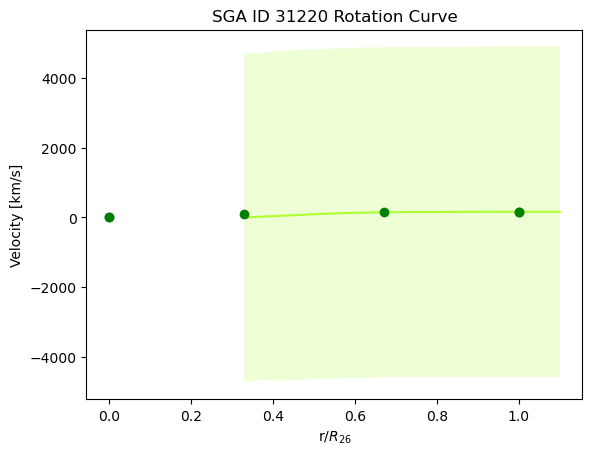

[5.87990806e+03 6.93820673e+01 2.89218456e+03 6.24440183e-07
 7.91749007e+03]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


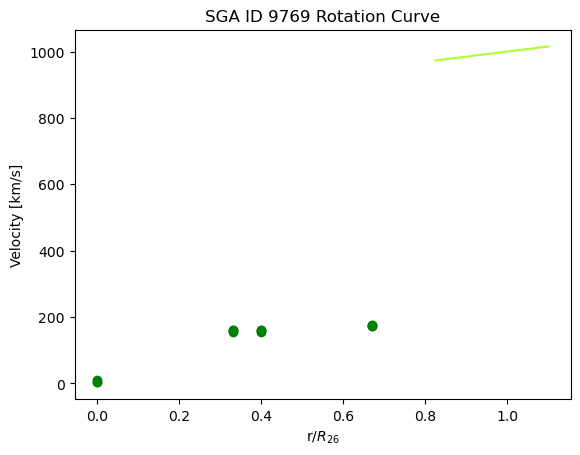

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


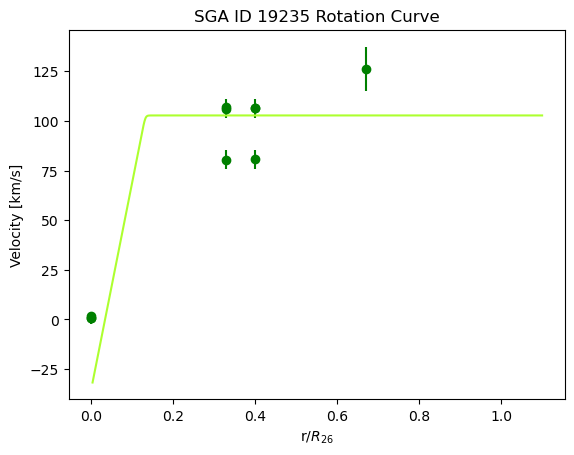

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


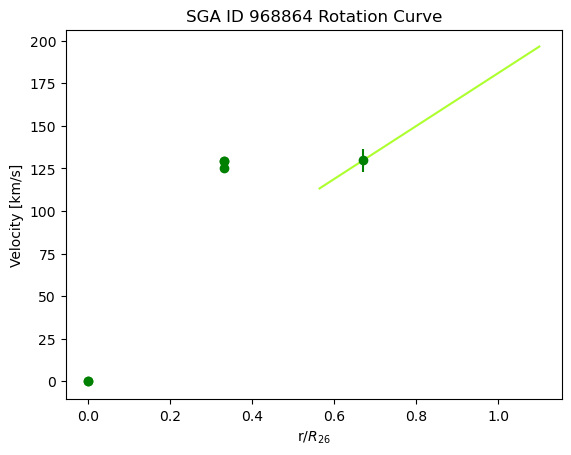

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


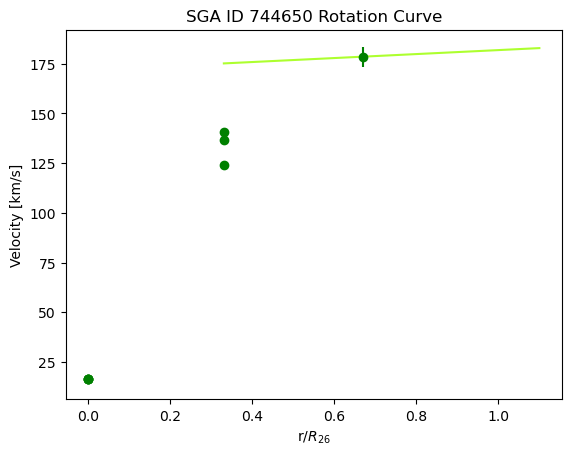

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/commo

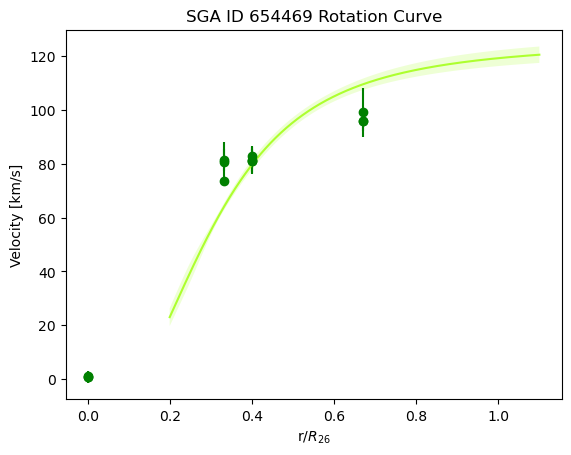

[6.75823973 0.03862162 0.07183272 0.02293109 4.14920683]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


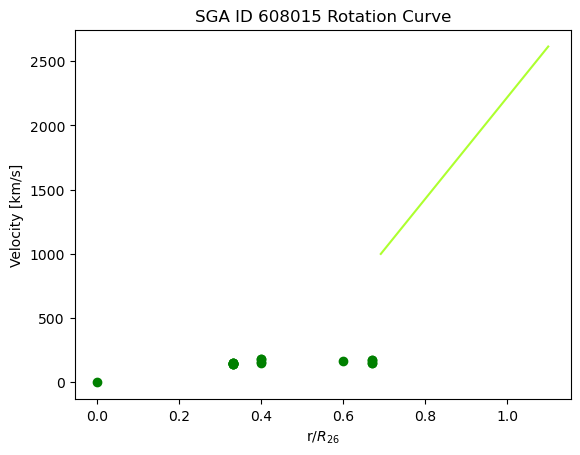

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


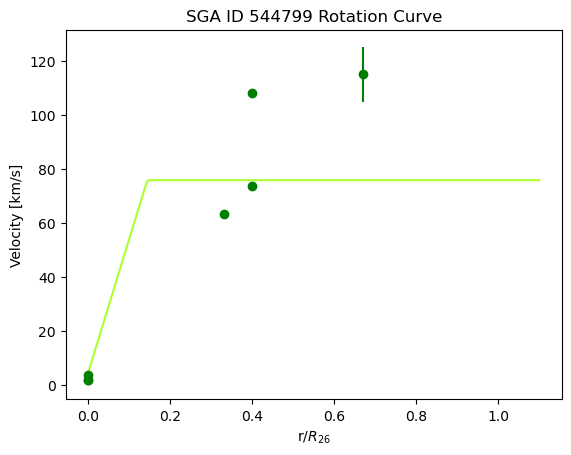

[nan nan nan nan nan]


/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/

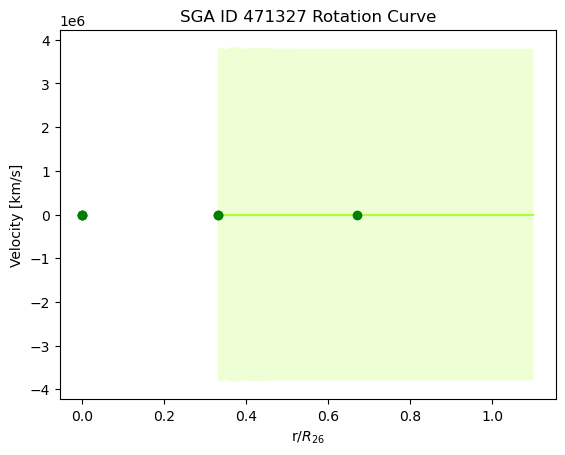

[1.05319589e+07 8.63351296e+04 8.72929811e+05 3.12343470e-08
 6.23893251e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


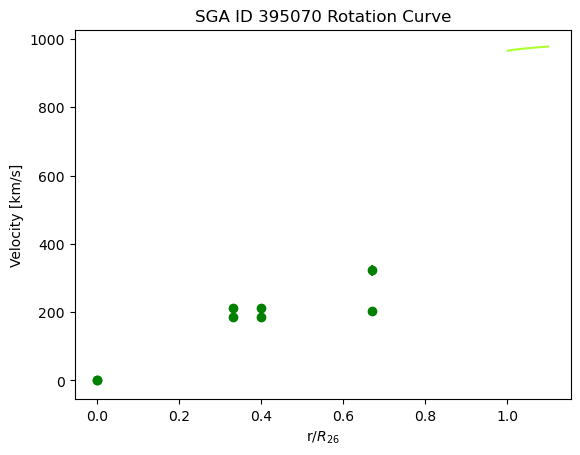

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


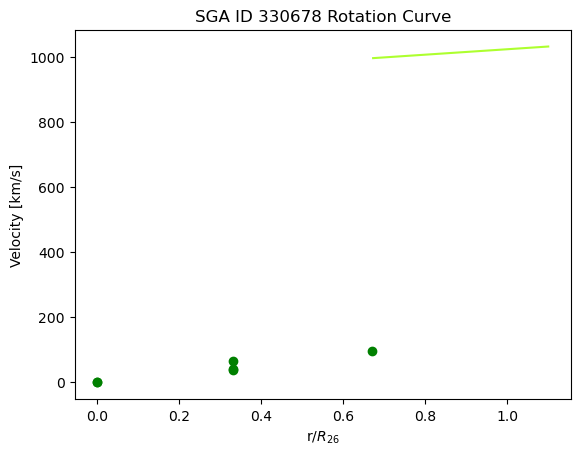

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


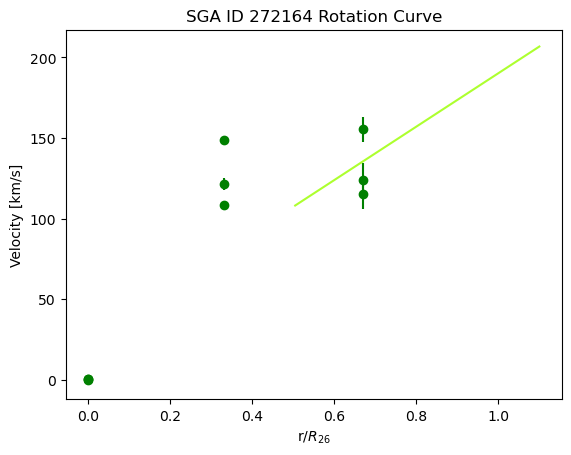

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


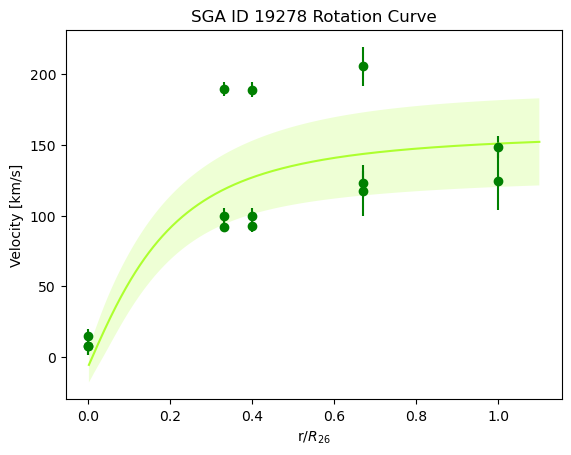

[1.08092885e+01 6.69414694e-02 8.00030537e-01 1.28814231e-03
 6.73393571e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


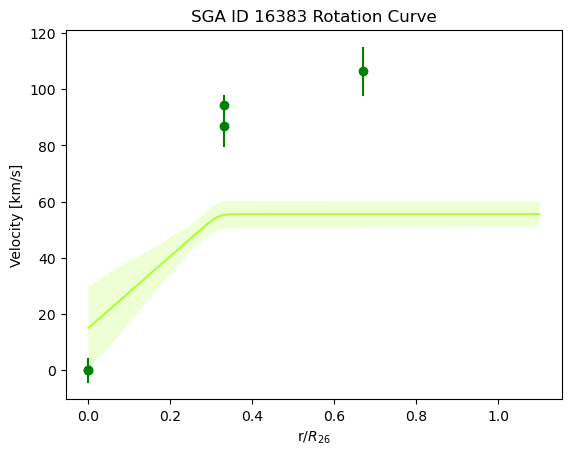

[12.61848059  0.14766646 42.41251457  0.14635614  9.48672929]


/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


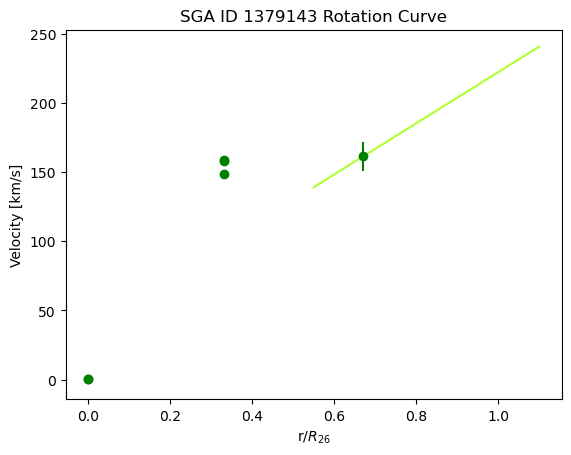

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


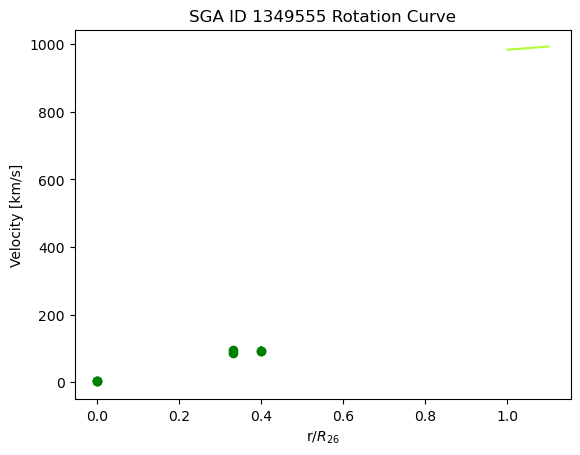

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


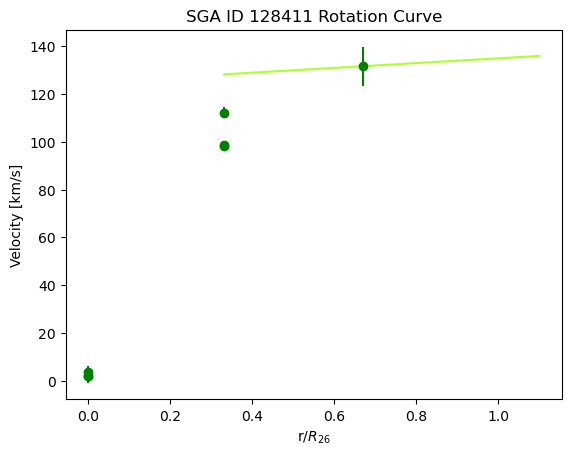

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykerne

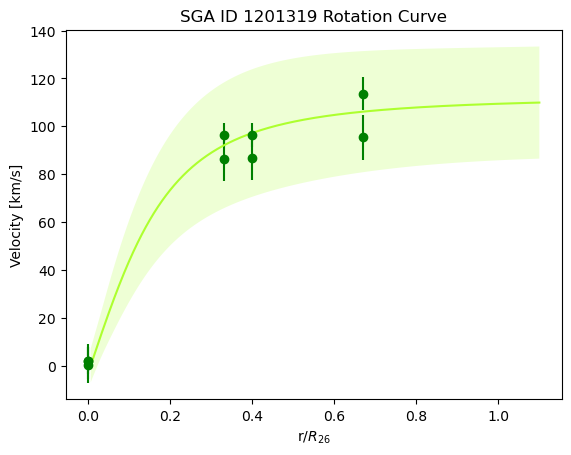

[2.72572676e+01 3.26285415e-01 4.47890831e+00 2.40767742e-04
 5.63957949e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350

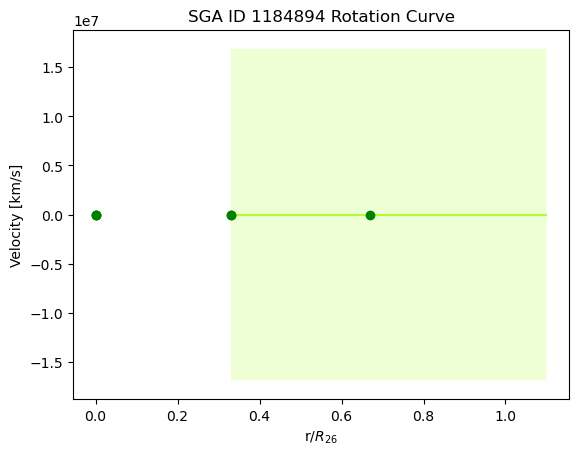

[3.94302478e+07 1.56496869e+04 2.28743537e+05 1.25930339e-09
 2.48003965e+07]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


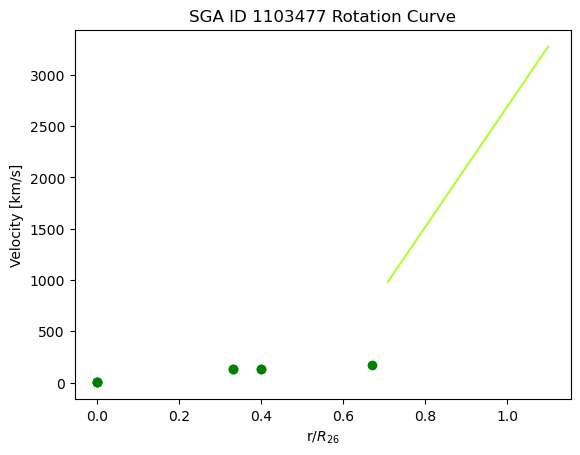

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


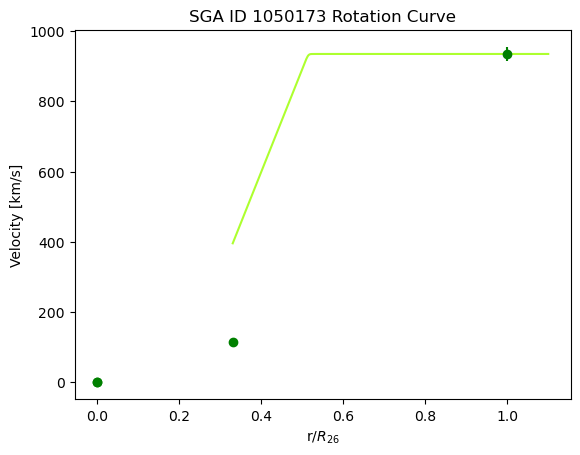

[nan nan nan nan nan]


/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/

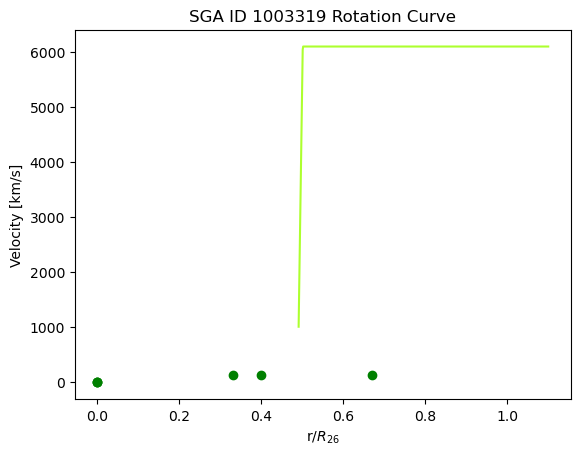

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


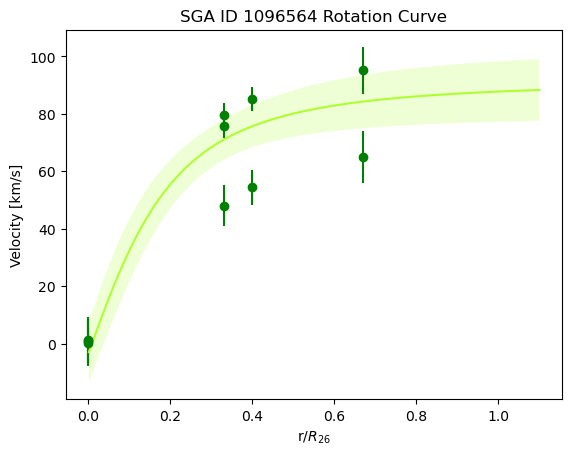

[8.06800327e+00 9.42307752e-02 5.91786548e-01 4.86873018e-03
 5.80617467e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


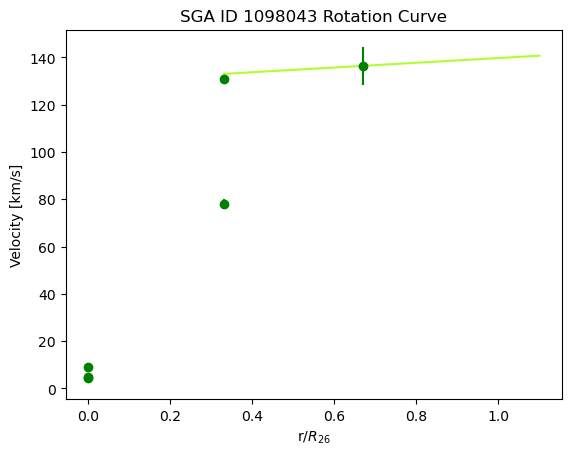

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


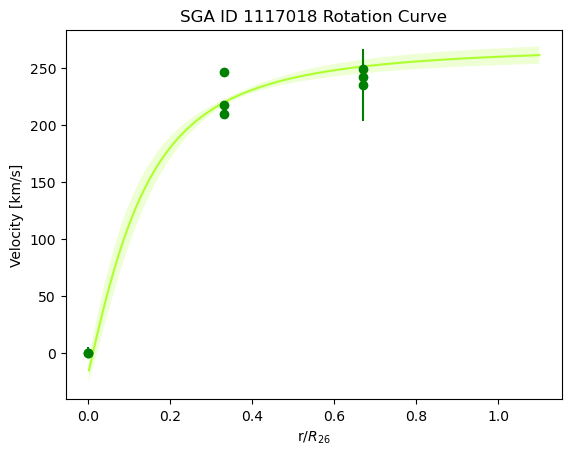

[7.14667523e+00 2.69539138e-02 1.82748505e-01 6.10284761e-04
 3.40960739e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykerne

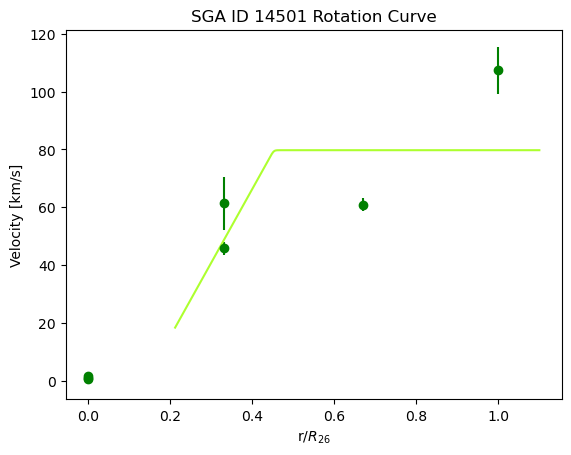

[9.69651365e+00 2.78583275e-02 1.97091633e+12 3.55558228e-03
 9.17866933e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


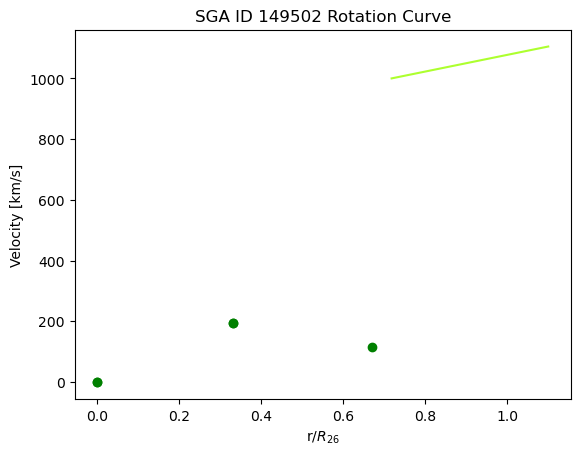

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350

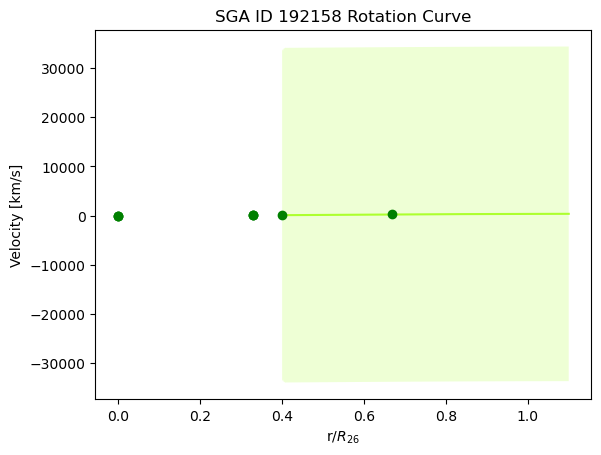

[7.47927699e+06 1.46103896e+04 9.01765351e+04 3.79240439e-09
 5.53446197e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


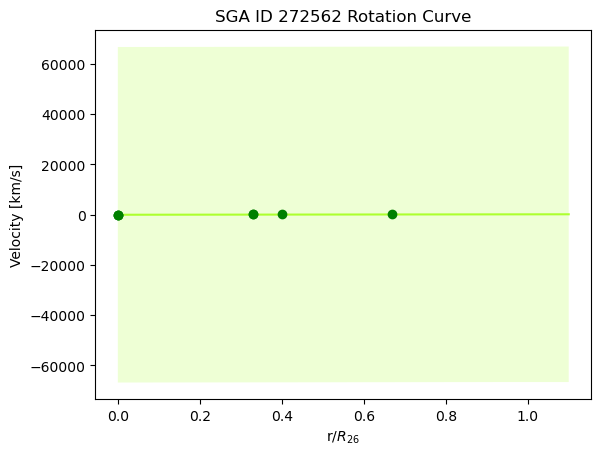

[4.26875089e+06 2.16133863e+04 5.03055919e+06 2.77705309e+03
 5.48481746e+05]


/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/

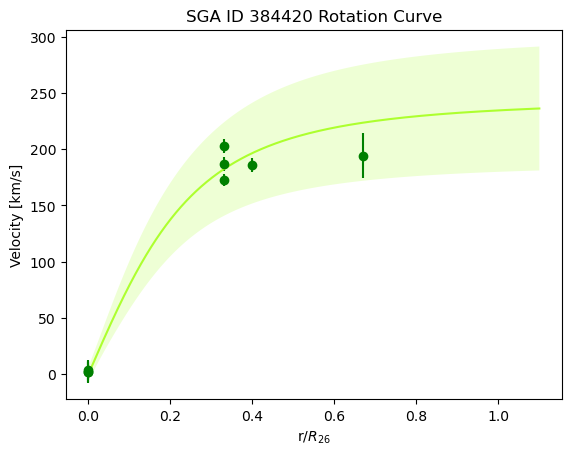

[5.57698888e+01 8.05162344e-02 1.10842476e+00 9.04218921e-04
 7.25922019e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],


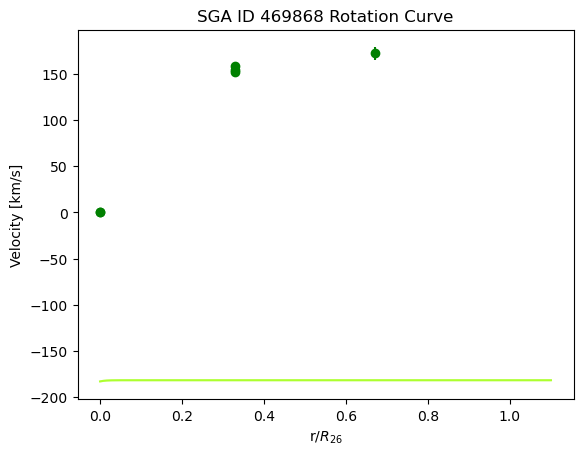

[34.88549658  0.22091293  0.64907567  0.21979528 34.82627922]


/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/

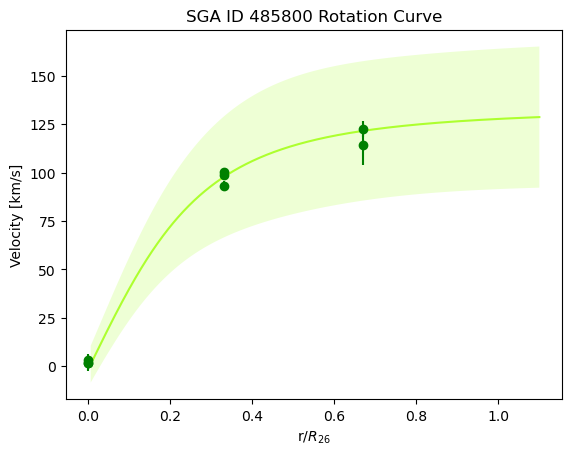

[6.68602208e+01 3.75428463e-01 6.48099276e+00 6.22096034e-05
 1.71918539e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykerne

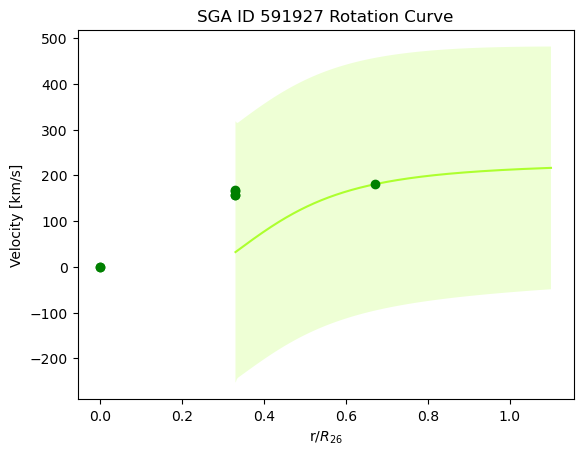

[1.13414187e+03 2.60001303e+00 1.43662088e+01 1.52221084e-06
 4.47926655e+02]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350

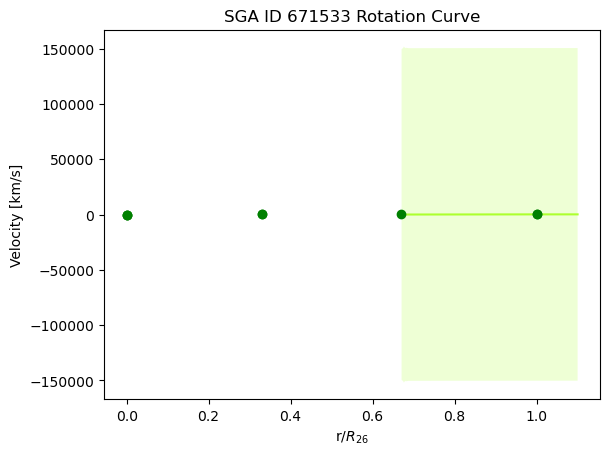

[4.06474740e+05 8.16531240e+02 6.16967029e+03 1.96698080e-08
 2.57846671e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


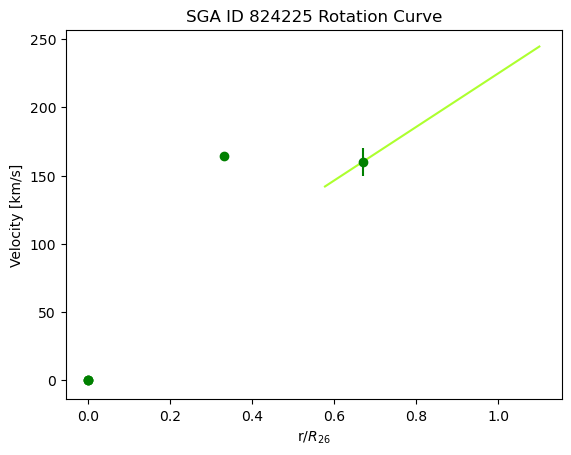

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


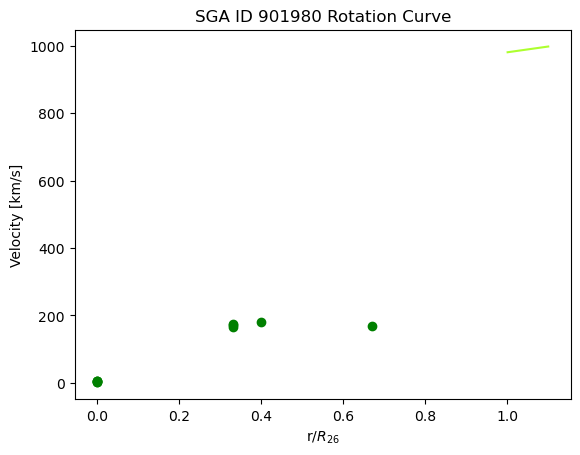

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


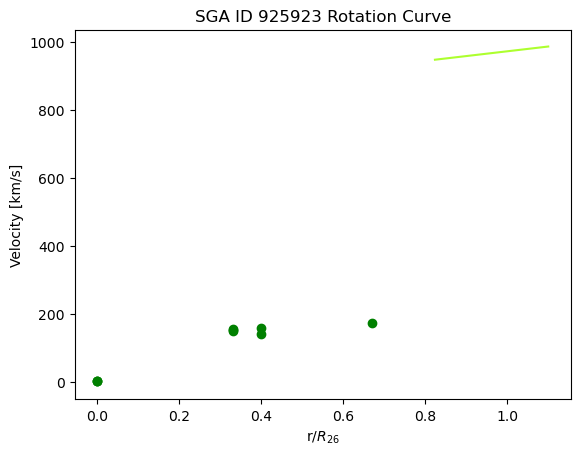

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350

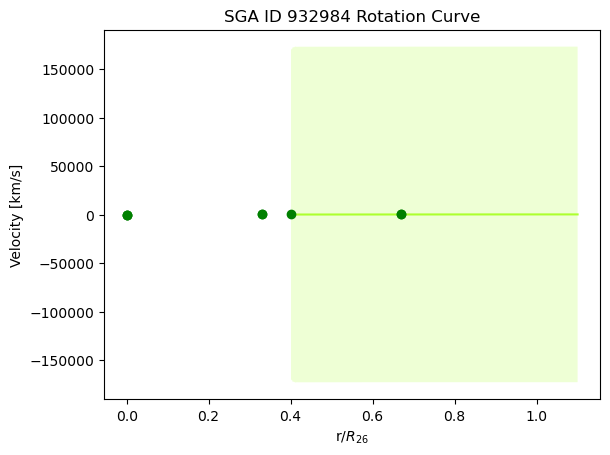

[8.01849244e+05 5.68145363e+03 1.22389677e+04 6.90392062e-08
 2.97266322e+05]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/commo

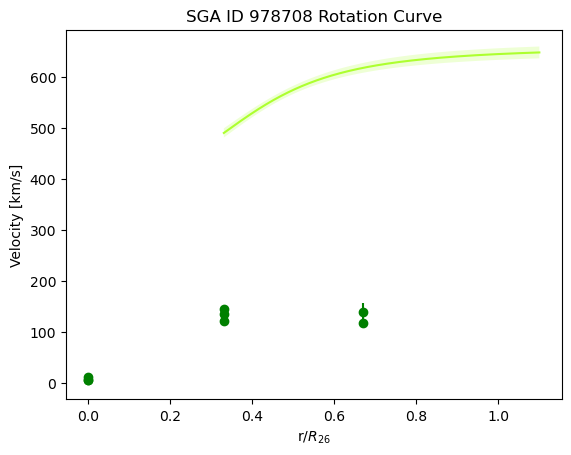

[7.94239852e+00 1.09332857e-02 9.96893473e-02 7.72792965e-04
 8.93531971e+00]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


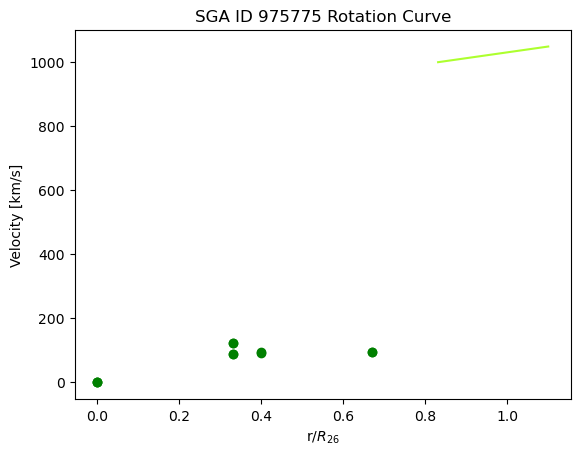

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


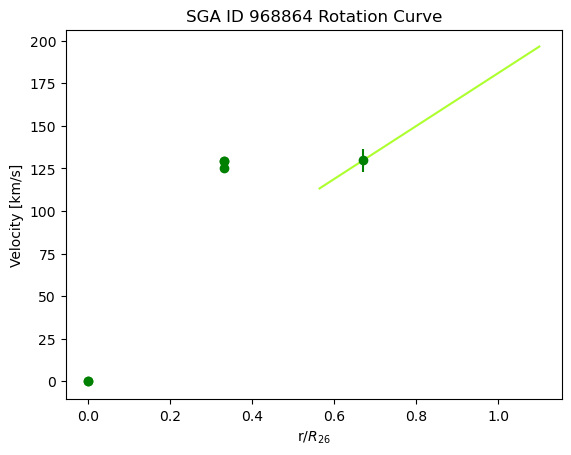

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


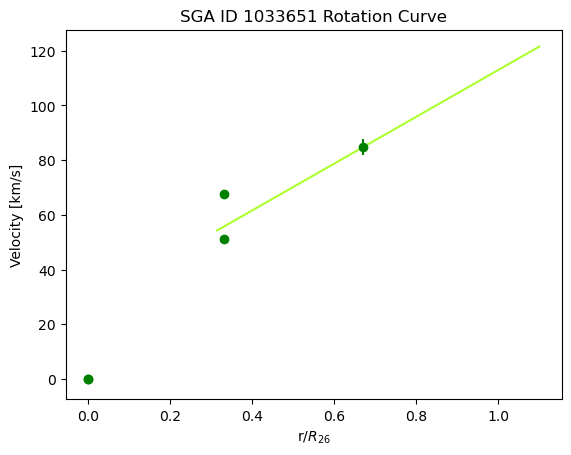

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


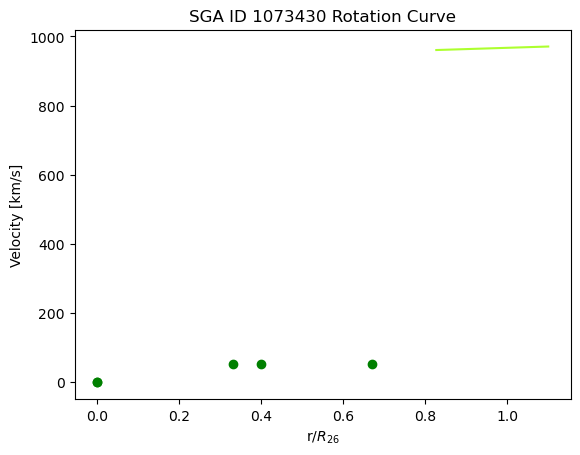

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


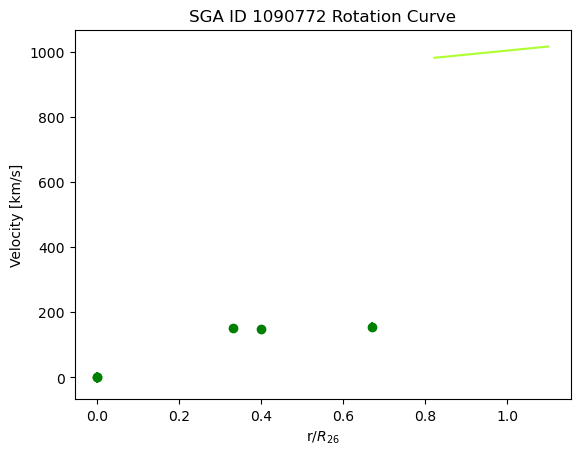

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


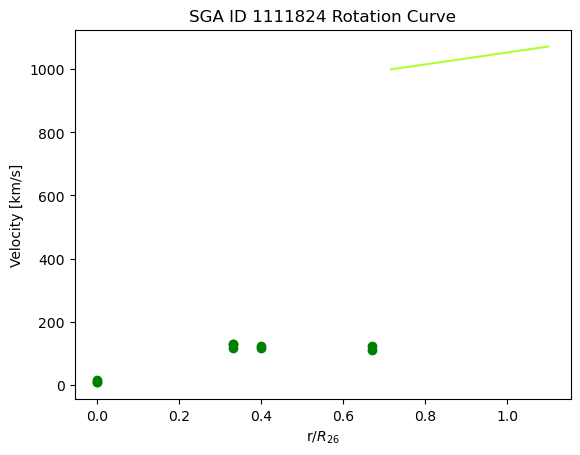

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


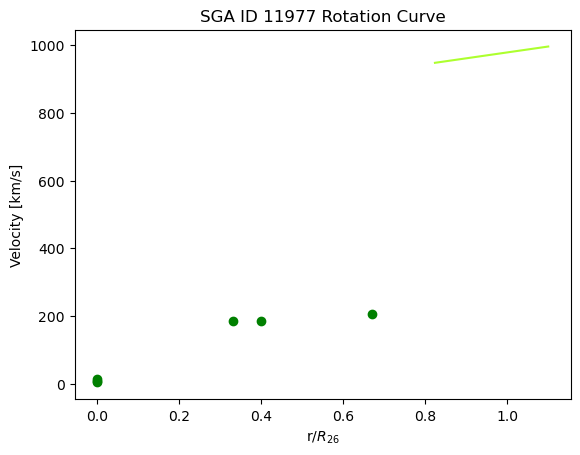

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/global/common/software/desi/perlmutter/desiconda/202404

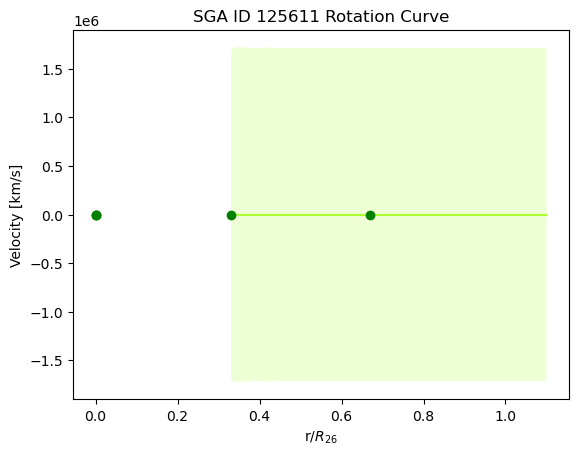

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


[1.33054375e+06 1.63106111e+04 1.30477237e+05 1.85595477e-08
 2.23565322e+06]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


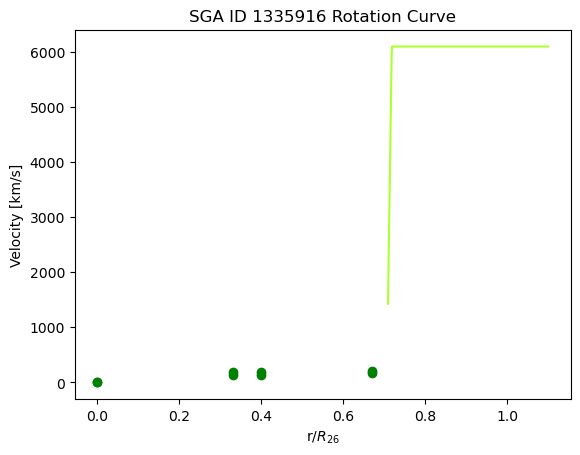

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


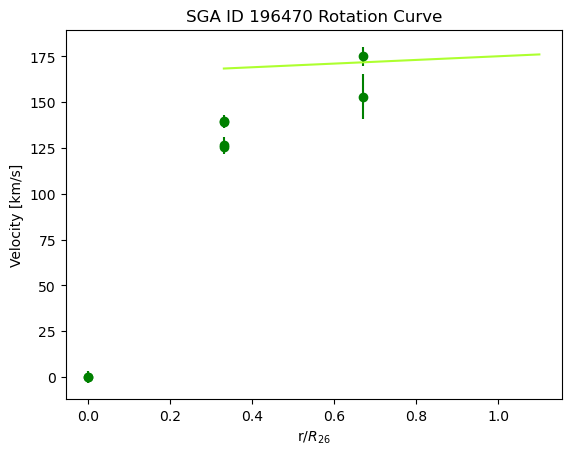

[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


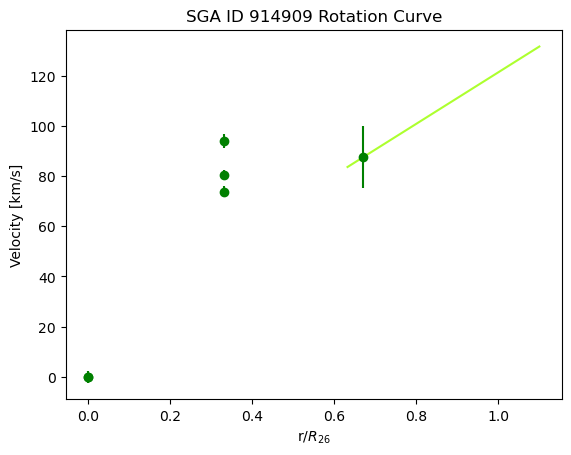

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)


[nan nan nan nan nan]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/2365880078.py:80: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: overflow encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: 

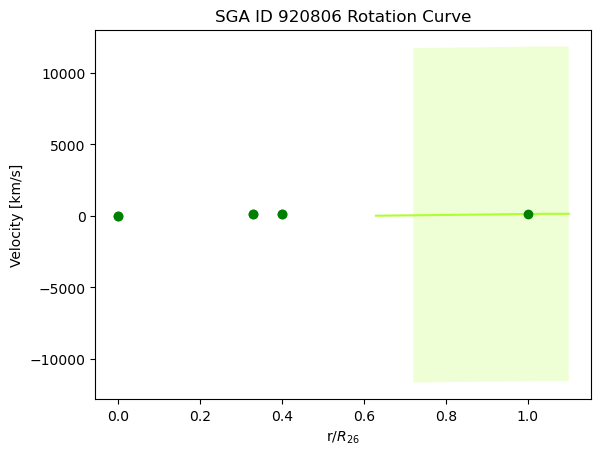

/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:282: UserWarning: Warning: converting a masked element to nan.
  hess[i, i] = (f(x + 2 * e_i) - 2 * f_x + f(x - 2 * e_i)) / (4. * hess[i, i])


[2.33505829e+04 1.68531593e+00 1.66993641e+05 8.94768108e+00
 1.92429624e+04]


/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/finite_difference.py:285: UserWarning: Warning: converting a masked element to nan.
  hess[i, j] = (f(x + e_i + e_j) - f(x + e_i - e_j)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/global/homes/j/jjpim/.local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/tmp/ipykernel_350730/1769431299.py:18: RuntimeWarning: invalid value encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


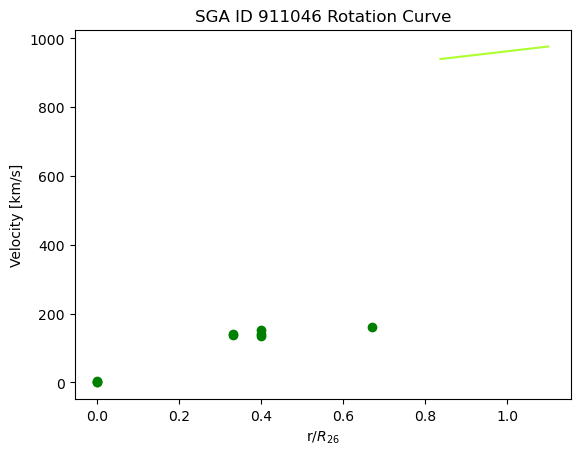

[nan nan nan nan nan]


In [22]:
for sga_id in rotcurvefits:
    sga_idx = SGA_dict[sga_id]
    axis_ratio = SGA['BA'][sga_idx]
    
    # calculate inclination
    inc = inclination_angle(axis_ratio)
    tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc
    
    # velocity cut <= 1000 
    v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VELOCITY'])
    verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VERR']
    radius = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['SKY_FIBER_DIST_R26']
    
    # calculate v rot and error 
    vrotate = v / (np.sin(inc))
    vrot = vrotate[np.abs(vrotate) <= 1000]
    vrotate_err = verr / (np.sin(inc))
    vrot_err = vrotate_err[np.abs(vrotate) <= 1000]
    r = radius[np.abs(vrotate) <= 1000]
    
    # initial guesses and bounds for v_max, r_turn, alpha
    alpha_guess = 2
    alpha_low = 0.001
    alpha_high = 100
    v_max_guess = np.max(vrot)
    v_max_low = 10
    v_max_high = 5100
    r_turn_guess = 0.3
    r_turn_low = 0.01
    r_turn_high = 1
    
    # initial guesses and bounds for r_center and v_sys
    r_center_guess = 0     
    r_center_low = -1      
    r_center_high = 1       

    v_sys_guess = 0       
    v_sys_low = -1000     
    v_sys_high = 1000        

    # put guesses + bounds into arrays
    guess = [v_max_guess, r_turn_guess, alpha_guess, r_center_guess, v_sys_guess]
    bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), 
              (alpha_low, alpha_high), (r_center_low, r_center_high), 
              (v_sys_low, v_sys_high)]
    
    # use minimize function
    result = minimize(chi_2, guess, method='Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
    # plot only if result succeeds
    if result.success:
        # Calculating errors
        hessian = ndt.Hessian(chi_2)
        hess = hessian(result.x, vrot, vrot_err, r)
        np.save('/pscratch/sd/j/jjpim/hessians/' + str(sga_id) + '_hessian.npy', hess)
        try:
            hess_inv = 2 * np.linalg.inv(hess)
            fit_params_err = np.sqrt(np.diag(np.abs(hess_inv)))
        except np.linalg.LinAlgError:
            fit_params_err = np.nan * np.ones(len(result.x))

        # updating mastertable
        tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
        tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
        tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
        tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
        
        tf_mastertable['VMAX_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[0]
        tf_mastertable['RTURN_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[1]
        tf_mastertable['ALPHA_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = fit_params_err[2]
        
        # create and indexing linear space
        rs = np.linspace(0, 1.1, 1000)
        vs = v_rot(rs - result.x[3], result.x[0], result.x[1], result.x[2]) + result.x[4]
        
        #plotting
        if not np.isnan(fit_params_err).all():
            N_samples = 10000
            try:
                random_sample = np.random.multivariate_normal(mean=[result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]],
                                                              cov=hess_inv, size=N_samples)
            except:
                print(str(sga_id) + ' plot sample failed')
            
            # get rid of bad samples in gaussian
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]
        
            y_sample = np.zeros((len(rs), len(good_randoms[:,0])))
            for i in range(len(rs)):
                for j in range(len(good_randoms[:,0])):
                    # Calculate values of curve at this location
                    y_sample[i][j] = v_rot(rs[i] - good_randoms[j][3], good_randoms[j][0],
                                           good_randoms[j][1], good_randoms[j][2]) + good_randoms[j][4]
            
            stdevs = np.nanstd(y_sample, axis=1)   
        
            plt.fill_between(rs, vs - stdevs, vs + stdevs, facecolor='greenyellow', alpha=0.2)
        
        plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
        plt.plot(rs, vs, color='greenyellow')
        plt.xlabel(r"r/$R_{26}$")
        plt.ylabel("Velocity [km/s]")
        plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")
        img_name = v_dir + '{}.jpg'.format(sga_id)
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
        plt.show()
        plt.close()
        
        print(fit_params_err)

In [23]:
modified_columns = ['ALPHA', 'RTURN', 'ROTCURVE_CHI2']

# Print the relevant columns for each SGA ID in sga_ids
for sga_id in rotcurvefits:
    # Get the rows where the SGA_ID matches and velocity cut is applied
    mask = np.logical_and(tf_mastertable['SGA_ID'] == sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)
    
    # Extract the relevant columns for those rows
    print(f"SGA ID: {sga_id}")
    print(tf_mastertable[mask][['SGA_ID'] + modified_columns])

SGA ID: 31220
SGA_ID       ALPHA              RTURN          ROTCURVE_CHI2   
------ ----------------- ------------------- ------------------
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
 31220 4.341311967441523 0.29332103293608697 0.5440589384101485
SGA ID: 9769
SGA_ID       ALPHA             RTURN        ROTCURVE_CHI2
------ ----------------- ------------------ -------------
  9769 99.99976308350169 0.9999999088480604           0.0
  9769 99.99976308350169 0.9999999088480604           0.0
  9769 99.99976308350169 0.9999999088480604           0.0
  9769 99.99976308350169 0.9999999088480604           0.0
  9769 99.99976308350169 0.9999999088480604           0.0
  9769 99.99976308350169 0.9999999088480604           0